# Expression performance

In [9]:
import iarray as ia
import numpy as np
import os
from time import time
import ctypes
import matplotlib.pyplot as plt
import numexpr as ne
import py2llvm as llvm
from py2llvm import float64, int32, Array
from numba import config, njit, threading_layer, prange


omp = ctypes.CDLL('libiomp5.so')
omp_set_num_threads = omp.omp_set_num_threads

max_num_threads = 4
nrep = 5

In [10]:
@njit(parallel=True)
def poly_numba(x):
    y = np.empty(x.shape, x.dtype)
    for i in prange(len(x)):
        y[i] = (x[i] - 1.35) * (x[i] - 4.45) * (x[i] - 8.5)
    return y

config.THREADING_LAYER = 'omp'

def poly_llvm(x, y):
    i = 0
    while i < x.shape[0]:
        y[i] = (x[i] - 1.35) * (x[i] - 4.45) * (x[i] - 8.5)
        i = i + 1
    return 0

signature = Array(float64, 1), Array(float64, 1), int32
poly_llvmc = llvm.compile(poly_llvm, signature, verbose=0)

In [11]:
# Define array params
shape = [512 * 512 * 256]
pshape = None
pshape2 = [128 * 1024]
bshape = pshape2

size = int(np.prod(shape))

res = []

for num_threads in range(max_num_threads):
    print(f"Num. threads: {num_threads + 1}")
    omp_set_num_threads(num_threads + 1)
    res_i = []

    # Numpy
    a1 = np.linspace(0, 10, size).reshape(shape)

    t = []
    ne.set_num_threads(num_threads + 1)
    for _ in range(nrep):
        t0 = time()
        b1 = eval("(x - 1.35) * (x - 4.45) * (x - 8.5)", {"x": a1})        
        t1 = time()
        t.append(round(size / 2**20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    # llvm
    a1 = np.linspace(0, 10, size).reshape(shape)
    
    t = []
    ne.set_num_threads(num_threads + 1)
    for _ in range(nrep):
        t0 = time()
        b1 = np.empty(size).reshape(shape)
        poly_llvmc(a1, b1)
        t1 = time()
        t.append(round(size / 2**20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))
    
    # numba
    a1 = np.linspace(0, 10, size).reshape(shape)

    t = []
    ne.set_num_threads(num_threads + 1)
    for _ in range(nrep):
        t0 = time()
        b1 = poly_numba(a1)
        t1 = time()
        t.append(round(size / 2**20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))
    
    # Numexpr
    a1 = np.linspace(0, 10, size).reshape(shape)

    t = []
    ne.set_num_threads(num_threads + 1)
    for _ in range(nrep):
        t0 = time()
        b1 = ne.evaluate("(x - 1.35) * (x - 4.45) * (x - 8.5)", local_dict={'x': a1})        
        t1 = time()
        t.append(round(size / 2**20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))
    
    # Plainbuffer
    cfg = ia.Config(eval_flags="iterblock", max_num_threads=num_threads + 1)
    ctx = ia.Context(cfg)

    a1 = ia.linspace(ctx, size, 0, 10, shape, pshape, "double")

    expr = ia.Expression(ctx)
    expr.bind("x", a1)
    expr.compile("(x - 1.35) * (x - 4.45) * (x - 8.5)")
    t = []
    for _ in range(nrep):
        t0 = time()
        b1 = expr.eval(shape, pshape, "double")
        t1 = time()
        t.append(round(size / 2**20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))
    
    # Superchunk without compression
    cfg = ia.Config(eval_flags="iterblock", max_num_threads=num_threads + 1, compression_level=0)
    ctx = ia.Context(cfg)

    a1 = ia.linspace(ctx, size, 0, 10, shape, pshape2, "double")

    expr = ia.Expression(ctx)
    expr.bind("x", a1)
    expr.compile("(x - 1.35) * (x - 4.45) * (x - 8.5)")
    t = []
    for _ in range(nrep):
        t0 = time()
        b1 = expr.eval(shape, pshape, "double")
        t1 = time()
        t.append(round(size / 2**20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    # Superchunk with compression
    cfg = ia.Config(eval_flags="iterblock", max_num_threads=num_threads + 1, compression_level=5)
    ctx = ia.Context(cfg)

    a1 = ia.linspace(ctx, size, 0, 10, shape, pshape2, "double")

    expr = ia.Expression(ctx)
    expr.bind("x", a1)
    expr.compile("(x - 1.35) * (x - 4.45) * (x - 8.5)")
    t = []
    for _ in range(nrep):
        t0 = time()
        b1 = expr.eval(shape, pshape, "double")
        t1 = time()
        t.append(round(size / 2**20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))
    
    res.append(res_i)

Num. threads: 1
Num. threads: 2
Num. threads: 3
Num. threads: 4


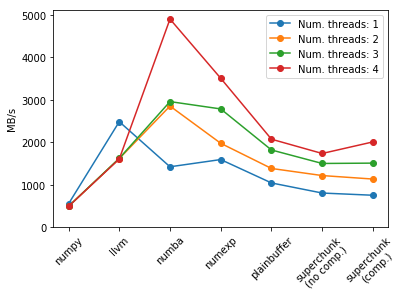

In [12]:
xticks = ("numpy", "llvm", "numba", "numexp", "plainbuffer", "superchunk\n(no comp.)", "superchunk\n(comp.)")
plt.xticks(range(len(xticks)), xticks)
for i in range(0, max_num_threads):
    plt.plot(xticks, res[i], "o-", label=f"Num. threads: {i+1}")
plt.xticks(rotation=45)
plt.ylabel("MB/s")
plt.ylim(0)
plt.legend()
plt.show()